In [36]:
from data.sampling import simple_sample, pair_sample
from models.velocity import VelocityMLP
from training import train_flow_matching
from inference import compare_inference, ode_backward
from score import clean_pred, score_s
import torch
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Specify a data distribution with classes

In [143]:
# Specific the data distribution
# C: number of classes, 
# N: number of dimensions of ambient space
C, N = 6, 2

sampler = simple_sample(C, N, dims=[1,2,1,2,2,1])


In [161]:
sampler_eg1 = sampler

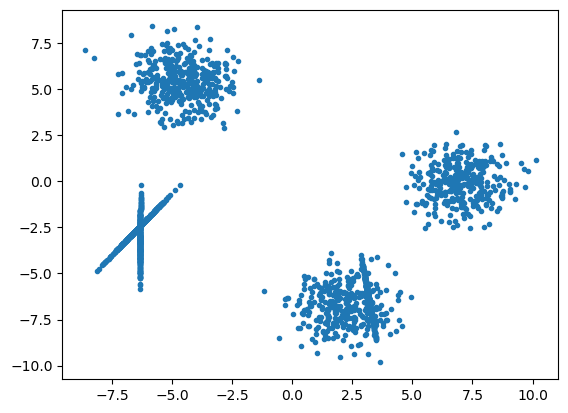

In [150]:
# Quick sanity check sample on the chosen device and plot the samples
x0, c = sampler(2048, device=device, class_idx = 6)
x0 = x0.detach().cpu().numpy()
plt.plot(x0[:, 0], x0[:, 1], '.')
plt.show()

# Train a conditional velocity to learn this distribution

In [162]:
# Model and training
model = VelocityMLP(num_classes=C, dim=N, hidden_dim=128, num_layers=4).to(device)
losses = train_flow_matching(
    model,
    sampler,
    num_steps=5000,
    batch_size=128,
    drop_label_prob=0.1,
    device=device,
)


step 100/5000 loss 18.684460
step 200/5000 loss 3.629756
step 300/5000 loss 2.818437
step 400/5000 loss 3.359714
step 500/5000 loss 2.828254
step 600/5000 loss 3.590796
step 700/5000 loss 2.090624
step 800/5000 loss 1.852653
step 900/5000 loss 2.354431
step 1000/5000 loss 3.125623
step 1100/5000 loss 1.978205
step 1200/5000 loss 2.620030
step 1300/5000 loss 2.573398
step 1400/5000 loss 2.602478
step 1500/5000 loss 3.263708
step 1600/5000 loss 2.847419
step 1700/5000 loss 2.511016
step 1800/5000 loss 3.066470
step 1900/5000 loss 2.197224
step 2000/5000 loss 2.503355
step 2100/5000 loss 2.157729
step 2200/5000 loss 2.305760
step 2300/5000 loss 2.248323
step 2400/5000 loss 2.290257
step 2500/5000 loss 3.156219
step 2600/5000 loss 2.634744
step 2700/5000 loss 2.164702
step 2800/5000 loss 3.355507
step 2900/5000 loss 1.846286
step 3000/5000 loss 2.433745
step 3100/5000 loss 1.854112
step 3200/5000 loss 2.405409
step 3300/5000 loss 1.762371
step 3400/5000 loss 2.886145
step 3500/5000 loss 2.

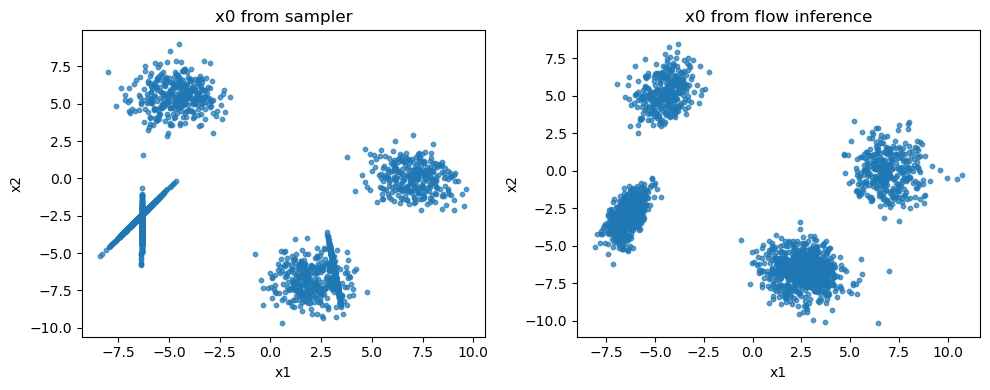

In [178]:
# Inference: Select K number of points and c_gen class labels (each with range {0, 1, ..., C}， 
# C standing for uniform random class)
K = 2000
c_gen = torch.ones(K, dtype=torch.long, device=device) * 6
x0_true, x0_gen = compare_inference(model, T=50, K=K, c=c_gen, sampler=sampler, device=device, guidance=1)

# x0_true 是 (K, N) 的 tensor
x_true = x0_true.detach().cpu().numpy()

# x0_gen 是 (x, c) 的 tuple
x_gen_tensor, c_gen_tensor = x0_gen
x_gen = x_gen_tensor.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 左图：真实样本（sampler）
axes[0].scatter(x_gen[:, 0], x_gen[:, 1], s=10, alpha=0.7)
axes[0].set_title("x0 from sampler")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

# 右图：生成样本（flow inference）
axes[1].scatter(x_true[:, 0], x_true[:, 1], s=10, alpha=0.7)
axes[1].set_title("x0 from flow inference")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

plt.tight_layout()
plt.show()

In [ ]:

# Score and clean prediction (fixed pretrained v)
x_clean = clean_pred(model, x_t, t, c)
s = score_s(model, x_t, t, c, g=1.0)